In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.ensemble
import sklearn.svm
import pathlib
import pickle

In [3]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [19]:
# Paths 
base_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS')
train_dataset_path = base_dir / '5c_Rad_Georef_SGC_PCA_Tiles/20230503_UnetTraining_SeparateTrainValDatasets/20210825_Olberg_PCA_TrainDataset'
val_dataset_path = base_dir / '5c_Rad_Georef_SGC_PCA_Tiles/20230503_UnetTraining_SeparateTrainValDatasets/20210825_Olberg_PCA_ValDataset'
class_dict_path =  base_dir / '4c_Rad_Georef_SGC_Tiles/tile_classes_merged_NGT.json'
random_forest_save_path = base_dir / 'X_SavedModels_RF_SVM/20210825_Olberg_RandomForest.pkl'

In [5]:
# Load datasets 
training_dataset = tf.data.experimental.load(str(train_dataset_path))
validation_dataset = tf.data.experimental.load(str(val_dataset_path))
print(f'Number of 4-tile batches in training dataset: {training_dataset.cardinality()}')
print(f'Number of 4-tile batches in validation dataset: {validation_dataset.cardinality()}')

Number of tiles in training dataset: 81
Number of tiles in validation dataset: 35


In [6]:
def collect_dataset_spectra(dataset):
    """ Collect annotated pixels in feature matrix X and label vector y """
    pixels_list = []
    label_list = []
    for image_tile,label_tile,weight_tile in dataset:
        annotated_mask = (label_tile > 0) # Label 0 corresponds to background (not annotated)
        pixels_list.append(image_tile[annotated_mask])
        label_list.append(label_tile[annotated_mask])
    X = np.concatenate(pixels_list)
    y = np.concatenate(label_list)
    return (X,y)

In [7]:
# Get data and labels for training data
X_train,y_train = collect_dataset_spectra(training_dataset)
print(X_train.shape)
print(y_train.shape)

(1957290, 8)
(1957290,)


In [8]:
# Get data and labels for validation data
X_val,y_val = collect_dataset_spectra(validation_dataset)
print(X_val.shape)
print(y_val.shape)

(844177, 8)
(844177,)


In [9]:
# Create a random forest model
rfc = sklearn.ensemble.RandomForestClassifier(
    n_estimators=30,            # Ensemble of 30 decision trees
    min_samples_leaf=15,        # Stop splitting data when number of samples < 10 (faster)
    max_samples=0.6)            # Use only 10% of data for each estimator (faster)

In [10]:
# Train classifier (takes about 1-2 minutes)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_samples=0.6, min_samples_leaf=15, n_estimators=30)

In [11]:
# Use classifier to make predictions on validation data
y_val_pred = rfc.predict(X_val)

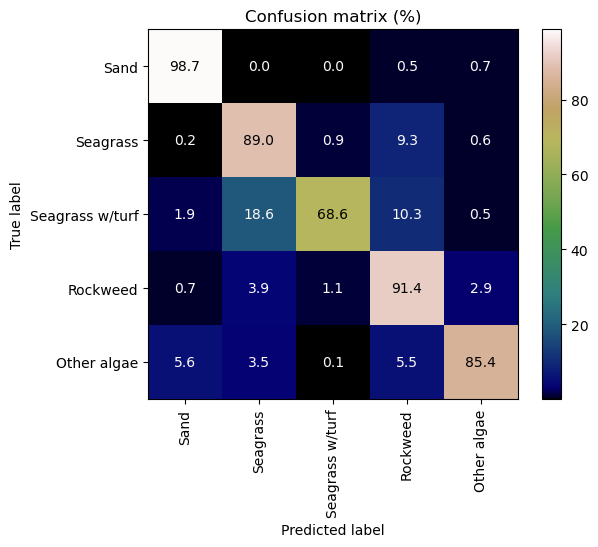

In [12]:
# Show confusion matrix
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
confusion_matrix = sklearn.metrics.confusion_matrix(y_val,y_val_pred,normalize='true')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix (%)')
plt.show()

We can see that
- Sand is classified with very high accuracy
- Among the non-sand classes there is a relatively even "spread" of misclassifiactions
- The largest single misclassification is "seagrass with turf" pixels being misclassified as seagrass, which makes sense, since these two classes are not easily separable, especially not on a pixel-per-pixel basis

NOTE: The dataset shuffle and split earlier in the notebook is random, and if the notebook is run several times, the confusion matrix will CHANGE somewhat between iterations. To get a more stable result, use e.g. K-fold crossvalidation.

In [13]:
def sample_weights_balanced(y):
    """ Create sample weigths which are inversely proportional to class frequencies 
    
    # Arguments:
    y        Numpy vector with (numerical) labels
    
    # Returns:
    sample_weights  Numpy vector with same shape as y
                    Classes with a low number of samples get higher weights
                    See 'balanced' option in
                    https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html
    
    # Notes
    - Useful in combination with score() function for various classifiers,
    to calculate a balanced score in case on unbalanced datasets
    """
    sample_weights = np.zeros(len(y),dtype=float)
    for label in np.unique(y_val):
        label_mask = (y_val == label)
        sample_weights[label_mask] = len(y)/np.count_nonzero(label_mask)
    return sample_weights

In [14]:
# Calculate classifier score (accuracy)
sample_weights = sample_weights_balanced(y_val)
val_score_unweighted = rfc.score(X_val,y_val)
val_score_weighted = rfc.score(X_val,y_val,sample_weight=sample_weights)

In [15]:
# Print classifier score
print(f'\"Raw\" classifier score (unweighted):     {val_score_unweighted}')
print(f'Balanced classifier score (weighted):    {val_score_weighted}')   
print(f'Mean value of confusion matrix diagonal: {np.mean(confusion_matrix.diagonal())}')

"Raw" classifier score (unweighted):     0.9204041332564142
Balanced classifier score (weighted):    0.8664343299966837
Mean value of confusion matrix diagonal: 0.8664343299966838


We can see that the balanced classifier score is lower than the unbalanced score. This is probably due to the high number of sand pixels, combined with the classifier's high performance for the sand class. The balanced score is identical to the mean value of diagonal elements in the (normalized) confusion matrix.

In [21]:
# Save the model
pickle.dump(rfc,open(random_forest_save_path,'wb'))